# Linear Regression

**Learning Objectives:** Learn to fit models to data using linear regression and evaluate the goodness of those fits.

## Imports

In [1]:
import numpy as np
from scipy import optimize as opt
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from ipywidgets import interact

In [3]:
import tensorflow as tf

## 1. Introduction

In Data Science it is common to start with data and develop a *model* of that data. Such models can help to explain the data and make predictions about future observations. In fields like Physics, these models are often given in the form of differential equations, whose solutions explain and predict the data. In most other fields, such differential equations are not known. Often, models have to include sources of uncertainty and randomness. Given a set of data, *fitting* a model to the data is the process of tuning the parameters of the model to *best* explain the data.

When a model has a linear dependence on its parameters, such as $a x^2 + b x + c$, this process is known as *linear regression*.  When a model has a non-linear dependence on its parameters, such as $ a e^{bx} $, this process in known as non-linear regression. Thus, fitting data to a model of $w x^2 + b $ is linear regression, because of its linear dependence on $w$ and $b$ (rather than $x^2$).

## 2. Fitting a straight line

A classical example of fitting a model is finding the slope and intercept of a straight line that goes through a set of data points $\{x_i,y_i\}$. For a straight line the model is:

$$
y_{model}(x) = wx + b
$$

Given this model, we can define a performance metric, or **cost function**, that quantifies the error the model makes. One commonly used metric is the [mean-squared error]() or MSE, which depends on the deviation of the model from each data point ($y_i - y_{model}(x_i)$).

$$
MSE = \frac{1}{N-2} \sum_{i=1}^N \left( y_i - y_{model}(x_i) \right)^2
$$

When the MSE is small, the model's predictions will be close the data points. Likewise, when the MSE is large, the model's predictions will be far from the data points. Given this, our task is to minimize the MSE with respect to the model parameters $\theta = [w, b]$ in order to find the best fit.

The factor $N-2$ is called the **degrees of freedom** and is equal to the number of data points minus the number of model parameters.

To illustrate linear regression, let's create a synthetic data set with a known slope and intercept, but random noise that is additive and normally distributed.

In [4]:
N = 50
w_true = 2
b_true = -1
dy = 2.0 # uncertainty of each point

np.random.seed(0)
xdata = 10 * np.random.random(N) # don't use regularly spaced data
ydata = w_true*xdata + b_true + np.random.normal(0.0, dy, size=N) # our errors are additive

And visualize our dataset:

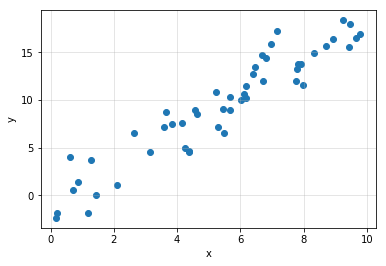

In [5]:
plt.scatter(xdata, ydata)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, alpha=0.4);

## 3. Fitting by hand

It is useful to see visually how changing the model parameters changes the MSE. By using IPython's `interact` function, we can create a user interface that allows us to pick a slope and intercept interactively and see the resulting line and MSE value.

Here is the function we want to minimize. Note how we have combined the two parameters into a single parameters vector $\theta = [w, b]$, which is the first argument of the function:

In [10]:
def mse(theta, x, y):
    w = theta[0]
    b = theta[1]
    return np.sum((y - b - w*x) ** 2)/(len(x)-len(theta))

In [11]:
def manual_fit(w, b):
    modely = w*xdata + b
    plt.plot(xdata, modely)
    plt.scatter(xdata, ydata)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(-2,12)
    plt.ylim(-5,20)
    plt.text(1, 10.0, '$MSE$={0:.2f}'.format(mse([w,b],xdata,ydata)))

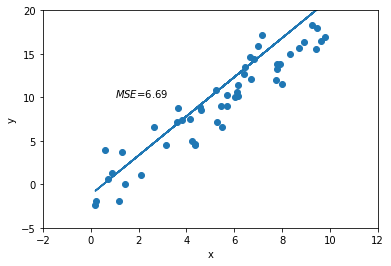

In [13]:
interact(manual_fit, w=(0.0,4.0,0.01), b=(-3.0,3.0,0.01));

Go ahead and play with the sliders and try to:

* Find the lowest value of the MSE.
* Find the "best" line through the data points.

You should see that these two conditions coincide.

## 2. Linear regression with TensorFlow

Let's fit a linear regression model using TensorFlow. We begin by declaring `Variable` and `placeholder` objects for our parameters and data:

In [ ]:
w = tf.Variable([1.0], dtype=tf.float32)
b = tf.Variable([1.0], dtype=tf.float32)
y = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32)

Here is our model and the performance metric or cost function:

In [65]:
model = w*x + b
mse = tf.reduce_sum((y - model)**2) # we are ommiting the DOF

Now create an optimizer. In general, you want to pick a learning parameter as large as possible to achieve faster convergence, but picking it too large will cause the algorithm to diverge.

In [15]:
opt = tf.train.GradientDescentOptimizer(0.0001)

In [16]:
train = opt.minimize(mse)

Create and initialize a session:

In [17]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

Now train the model:

In [18]:
for i in range(8000):
    sess.run(train, {x: xdata, y: ydata})
    # print(sess.run(mse, {x: xdata, y: ydata}))

Here are the predicted parameters:

In [66]:
w_hat, b_hat = sess.run([w, b])
w_hat, b_hat

(array([ 1.93854153], dtype=float32), array([-1.01438689], dtype=float32))

And the final value of the MSE:

In [20]:
sess.run(mse, {x: xdata, y: ydata})

171.1055

Let's visualize the results by evaluating the model at at the x data points:

In [23]:
ymodel = sess.run(model, {x: xdata})

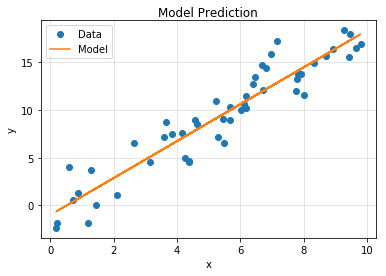

In [59]:
plt.plot(xdata, ydata, 'o', label='Data')
plt.plot(xdata, ymodel, '-', label='Model')
plt.grid(True, alpha=0.4)
plt.title("Model Prediction")
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

## 3. Understanding errors in linear regression

When performing linear regression of a two-dimensional dataset such as this, it is simply to visualize the results by making a scatter + line chart of y versus x. Such of visualization provides a quick picure of how well the model works. However, in higher dimensions, this visualization is not possible. Because of this we need to have systematic quantiative approach for evaluating the errors in a regression model.

The first measure of the error is the cost function itself, or in this case the mean-squared error. The challenge with the MSE is that it is a single number that is hard to interpret. However, if you are comparing multiple models, the MSE will give you a good sense of the relative error between the models.

The second measure of error are the **residuals**, which are simple the differences between the actual and predicted values:

$$ \epsilon_i = y_i - y_{model}(x_i) $$

This can be computed as follows:

In [35]:
residuals = sess.run(y - model, {x: xdata, y: ydata})

The advantage of the residuals is that they can be visualized in a simple histogram, regardless of the number of dimensions:

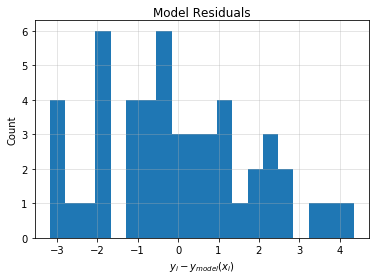

In [56]:
plt.hist(residuals, bins=20)
plt.grid(True, alpha=0.4)
plt.title('Model Residuals')
plt.ylabel('Count')
plt.xlabel('$y_i - y_{model}(x_i)}$');

The variance or standard deviation of these residuals will give us a measure of the average error our model is making:

In [41]:
residuals.std(), residuals.var()

(1.8498945, 3.4221096)

Notice, the standard deviation is very close to the $\sigma=2.0$ we used for the error term when we generated the original dataset! It turns out that linear regression assumes that errors are normally distributed and we have found an estimate of the $\sigma$ in the original dataset.

A third error metric is known as the **coefficient of determination**, or $R^2$. The idea of $R^2$ is to compare the errors made by our model to benchmark model: namely a horizontal line with a value of the average value of the data. Here is a visualization of that model:

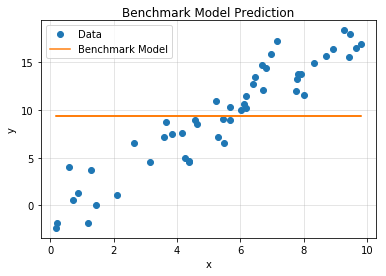

In [60]:
plt.plot(xdata, ydata, 'o', label='Data')
plt.plot(xdata, np.ones_like(xdata)*ydata.mean(), '-', label='Benchmark Model')
plt.grid(True, alpha=0.4)
plt.title('Benchmark Model Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

 Here are the residuals of that model:

In [53]:
benchmark_residuals = ydata - ydata.mean();

And a visualization of them:

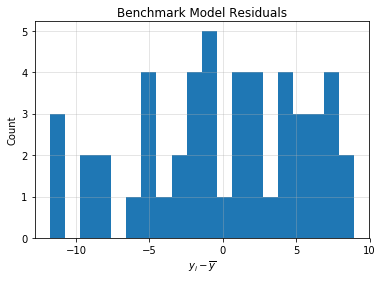

In [61]:
plt.hist(benchmark_residuals, bins=20);
plt.grid(True, alpha=0.4)
plt.title('Benchmark Model Residuals')
plt.ylabel('Count')
plt.xlabel('$y_i - \overline{y}$');

The idea of $R^2$ is that we will assess our actual model by comparing the its residuals to those of this benchmark model. Let's look at the standard deviation and variance of the residuals of the benchmark model:

In [55]:
benchmark_residuals.std(), benchmark_residuals.var()

(5.5927982640499838, 31.279392422360512)

Indeed, in this case, the residual variance of our model is significantly less than the residual variance of the benchmark model. Let's compute the ratio of the two:

In [62]:
residuals.var()/benchmark_residuals.var()

0.10940460599981133

This tells us that compared to the benchmark, our model gives an eror variance of about 10%. To compute the value of $R^2$, we compute $1.0$ minus this ratio:

In [64]:
R2 = 1.0 - residuals.var()/benchmark_residuals.var()
R2

0.89059539400018872

Thus, we see that $R^2$ has the following properties:

* $ R^2 \leq 1.0 $.
* A value of $R^2=1.0$ is the best possible scenario.
* A value of $R^2=0.0$ means our model has the same residual properties as the benchmark.
* A value of $R^2<0.0$ means our model is worse than the benchmark.

To conclude our discussion about errors in regression problems, here is a checklist of things to always do after you fit a regression model:

* If you can (two-dimensions), always plot the model results with the raw data.
* Always compute the residuals and plot them on a histogram.
* Always compute $R^2$.

## 4. Model selection

In this notebook, we started with a model and used that model to generate data. This was done to make it easy to check the predicted model parameters with the true values used to create the data set. However, in the real world, you almost never know the model underlying the data. Because of this, there is an additional step called **model selection** where you have to figure out a way to pick a good model. This is a notoriously difficult problem, especially when the randomness in the data is large.

* Pick the simplest possible model. In general picking a more complex model will give a better fit and an $R^2$ closer to 1. However, it won't be a useful model and will make poor predictions about future data. This is known as [overfitting](http://en.wikipedia.org/wiki/Overfitting).
* Whenever possible, pick a model that has a underlying theoretical foundation or motivation. For example, in Physics, most of our models come from well tested differential equations.
* There are more advanced methods, such as [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion), [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) that can assist in this model selection process.